<a href="https://colab.research.google.com/github/tcharos/NLP-Toxicity-Detection/blob/main/AIDL_CS01_NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIDL_B_CS01: Advanced NLP Project

1. LSTM Toxicity Detection (Custom & GloVe Embeddings)
2. BERT-alike STS-b Semantic Similarity (PyTorch/HF)
3. Custom RAG Mechanism
5. LLM Tuning with DPO (Gordon Ramsay Alignment)


In [ ]:
import os
import sys

# ==========================================================
# 1. Environment Detection & Constants
# ==========================================================
IN_COLAB = 'google.colab' in sys.modules
BASE_DIR = "/content" if IN_COLAB else "."
TOXICITY_PATH = os.path.join(BASE_DIR, "data_sets/toxicity")

# ==========================================================
# 2. Dependency Installation
# ==========================================================
if IN_COLAB:
    print("Running in Google Colab. Installing NLP stack...")
    !pip install -q -U transformers datasets accelerate peft trl sentence-transformers
else:
    print("Running locally. Checking Mac-specific requirements...")
    !{sys.executable} -m pip install -q "tensorflow==2.16.2" "tensorflow-macos==2.16.2" "tf-keras~=2.16"
    !{sys.executable} -m pip install -q -U transformers datasets accelerate peft trl sentence-transformers

# ==========================================================
# 3. Keras Backend Configuration (CRITICAL: Must be before Keras imports)
# ==========================================================
os.environ["KERAS_BACKEND"] = "tensorflow"

# ==========================================================
# 4. Comprehensive Imports
# ==========================================================
# --- Core Libraries ---
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# --- Metrics ---
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import f1_score, confusion_matrix

# --- PyTorch/Transformers/Datasets ---
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments
)

# --- DPO/PEFT (Task 5) ---
from peft import LoraConfig, get_peft_model
from trl import DPOTrainer

# --- Keras/TensorFlow Layers (Task 1) ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ==========================================================
# 5. Hardware Verification
# ==========================================================
print(f"\nTensorFlow Version: {tf.__version__}")
# Check for Apple Silicon (Metal) or CUDA
print("Num GPUs Available (TF): ", len(tf.config.list_physical_devices('GPU')))

HAS_MPS = torch.backends.mps.is_available()
HAS_CUDA = torch.cuda.is_available()

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("PyTorch Device: Mac GPU (Metal)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("PyTorch Device: Colab GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("PyTorch Device: CPU")

In [ ]:
os.makedirs(TOXICITY_PATH, exist_ok=True)

def download_toxicity_data():
    urls = {
        "train.csv": "https://raw.githubusercontent.com/Sreyan88/Toxicity-Detection-in-Spoken-Utterances/main/data/train.csv",
        "valid.csv": "https://raw.githubusercontent.com/Sreyan88/Toxicity-Detection-in-Spoken-Utterances/main/data/valid.csv",
        "test.csv": "https://raw.githubusercontent.com/Sreyan88/Toxicity-Detection-in-Spoken-Utterances/main/data/test.csv"
    }

    # Ensure the parent directory exists
    os.makedirs(TOXICITY_PATH, exist_ok=True)

    for name, url in urls.items():
        local_file = os.path.join(TOXICITY_PATH, name)
        if not os.path.exists(local_file):
            print(f"Fetching {name} from GitHub...")

            # FIXED: fname is just the name; cache_dir and cache_subdir handle the path
            tf.keras.utils.get_file(
                fname=name,
                origin=url,
                cache_dir=BASE_DIR,          # e.g., "." or "/content"
                cache_subdir="data_sets/toxicity" # The relative folder path
            )

download_toxicity_data()
print("\nInitialization Complete. All systems ready.")

### Functions

In [ ]:
def load_with_encoding(filename):
    try:
        return pd.read_csv(filename, encoding='utf-8')
    except UnicodeDecodeError:
        print(f"UTF-8 failed for {filename}, falling back to latin1")
        return pd.read_csv(filename, encoding='latin1')

def evaluate_binary(y_true, y_pred_probs, model_name="LSTM Model"):
    """
    Evaluates Task 1: Toxicity Detection.
    Expects y_pred_probs as probabilities (0 to 1).
    """
    # Convert probabilities to binary classes
    y_pred = (np.array(y_pred_probs) > 0.5).astype(int)

    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n--- Binary Classification: {model_name} ---")
    print(f"F1-Score: {f1:.4f}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Clean', 'Toxic'], yticklabels=['Clean', 'Toxic'])
    plt.title(f'Toxicity Confusion Matrix\n{model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return f1, cm

def evaluate_stsb(y_true, y_pred, model_name="BERT Model"):
    """
    Evaluates Task 2: STS-b Semantic Similarity.
    Expects y_pred as float regression scores.
    """
    # 1. Compute Official Metrics (Pearson & Spearman)
    pearson_val, _ = pearsonr(y_true, y_pred)
    spearman_val, _ = spearmanr(y_true, y_pred)

    # 2. Prepare Confusion Matrix (Discretize 0-5)
    y_true_int = np.rint(y_true).astype(int)
    y_pred_int = np.clip(np.rint(y_pred), 0, 5).astype(int)
    cm = confusion_matrix(y_true_int, y_pred_int)

    print(f"\n--- STS-b Regression: {model_name} ---")
    print(f"Pearson Correlation:  {pearson_val:.4f}")
    print(f"Spearman Correlation: {spearman_val:.4f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f'STS-b Quantized Confusion Matrix\n{model_name}')
    plt.ylabel('Actual (Rounded)')
    plt.xlabel('Predicted (Rounded)')
    plt.show()

    return pearson_val, spearman_val

## 1. Toxicity Detection with LSTM (Custom & GloVe Embeddings)

In [ ]:
### 1.1. Data Loading and Preparation

DATA_PATH = os.path.join(BASE_DIR, "data_sets/toxicity/")

train_df = load_with_encoding(os.path.join(DATA_PATH, "train.csv"))
valid_df = load_with_encoding(os.path.join(DATA_PATH, "valid.csv"))
test_df = load_with_encoding(os.path.join(DATA_PATH, "test.csv"))

X_train, y_train = train_df['text'].astype(str), train_df['label2a']
X_valid, y_valid = valid_df['text'].astype(str), valid_df['label2a']
X_test, y_test = test_df['text'].astype(str), test_df['label2a']

MAX_WORDS = 10000
MAX_LEN = 60
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN)
X_valid_pad = pad_sequences(tokenizer.texts_to_sequences(X_valid), maxlen=MAX_LEN)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
def build_lstm(embedding_layer):
    model = Sequential([
        embedding_layer,
        SpatialDropout1D(0.2),
        # On Mac, avoid recurrent_dropout=0.2 for significantly faster GPU execution
        LSTM(64, dropout=0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
### 1.2. Model 1: LSTM with Custom Learned Embeddings

# --- PART A: CUSTOM EMBEDDINGS ---
print("Training LSTM with Custom Embeddings...")
custom_emb_layer = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)
model_custom = build_lstm(custom_emb_layer)

model_custom.fit(X_train_pad, y_train, validation_data=(X_valid_pad, y_valid), epochs=5, batch_size=32)

In [ ]:
custom_probs = model_custom.predict(X_test_pad).flatten()

evaluate_binary(y_test, custom_probs, model_name="LSTM (Custom Embeddings)")

In [ ]:
# --- PART B: GLOVE EMBEDDINGS ---
def get_glove_matrix(path, word_index, emb_dim):
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    matrix = np.zeros((len(word_index) + 1, emb_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            matrix[i] = embedding_vector
    return matrix

# ACTION: Update this path to your local glove file
GLOVE_PATH = os.path.join(BASE_DIR, "glove.6B.100d.txt")

if not os.path.exists(GLOVE_PATH):
    if IN_COLAB:
        print("Downloading GloVe for Colab...")
        !wget http://nlp.stanford.edu/data/glove.6B.zip
        !unzip -j glove.6B.zip "glove.6B.100d.txt" -d {BASE_DIR}
    else:
        print(f"Please ensure GloVe is at {GLOVE_PATH}")

try:
    embedding_matrix = get_glove_matrix(GLOVE_PATH, tokenizer.word_index, EMBEDDING_DIM)
    glove_emb_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
                                input_length=MAX_LEN, trainable=False)

    print("\nTraining LSTM with GloVe Embeddings...")
    model_glove = build_lstm(glove_emb_layer)
    model_glove.fit(X_train_pad, y_train, validation_data=(X_valid_pad, y_valid), epochs=5, batch_size=32)
except FileNotFoundError:
    print(f"\nSkipping GloVe: Could not find {GLOVE_PATH}")

In [ ]:
glove_probs = model_glove.predict(X_test_pad)

evaluate_binary(y_test, glove_probs, model_name="LSTM (GloVe Embeddings)")

## 2. Semantic Similarity (STS-b) with BERT-alike Models (PyTorch/HF)

In [ ]:
# data_files = {
#     "train": "./data_sets/sts_b/train.jsonl",
#     "validation": "./data_sets/sts_b/validation.jsonl",
#     "test": "./data_sets/sts_b/test.jsonl"
# }

raw_datasets = load_dataset("glue", "stsb")

In [16]:
def preprocess_sts(examples, tokenizer):
    # STS-b expects two sentences and a float label
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

def train_transformer(model_id, label_name="BERT"):
    print(f"\n--- Training {label_name} ({model_id}) ---")

    tokenizer = AutoTokenizer.from_pretrained(model_id)

    tokenized_datasets = raw_datasets.map(lambda x: preprocess_sts(x, tokenizer), batched=True)
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=1)

    training_args = TrainingArguments(
        output_dir=f"./results_{label_name.lower()}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        remove_unused_columns=True,

        # FIX: Use bf16 if available (more stable than fp16), otherwise stick to fp32
        # This prevents the 'constant output' issue that causes nan correlations
        fp16=HAS_CUDA and not torch.cuda.is_bf16_supported(),
        bf16=HAS_CUDA and torch.cuda.is_bf16_supported(),

        # Ensure gradients don't explode
        max_grad_norm=1.0,

        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
    )

    trainer.train()

    return trainer, tokenized_datasets["validation"]

In [17]:
# Model 1: BERT
trainer_bert, val_data_bert = train_transformer("bert-base-uncased", "BERT")


--- Training BERT (bert-base-uncased) ---


Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.504682
2,0.867800,0.501506
3,0.336100,0.498184


In [22]:
bert_results = trainer_bert.predict(val_data_bert)
preds_bert = bert_results.predictions.flatten()
true_labels_bert = np.array(val_data_bert["labels"])

print("--- BERT Prediction Analysis ---")
print("First 10 predictions: ", preds_bert[:10])
print("Unique predictions:   ", len(np.unique(preds_bert)))
print("Std Deviation:        ", np.std(preds_bert))

print("\n--- Label Analysis ---")
print("First 10 true labels: ", true_labels_bert[:10])

--- BERT Prediction Analysis ---
First 10 predictions:  [4.875    4.5625   4.8125   2.03125  2.640625 2.765625 4.90625  2.046875
 4.75     4.78125 ]
Unique predictions:    516
Std Deviation:         1.4861807

--- Label Analysis ---
First 10 true labels:  [5.         4.75       5.         2.4000001  2.75       2.61500001
 5.         2.33299994 3.75       5.        ]



--- STS-b Regression: BERT-Base ---
Pearson Correlation:  0.8894
Spearman Correlation: 0.8850


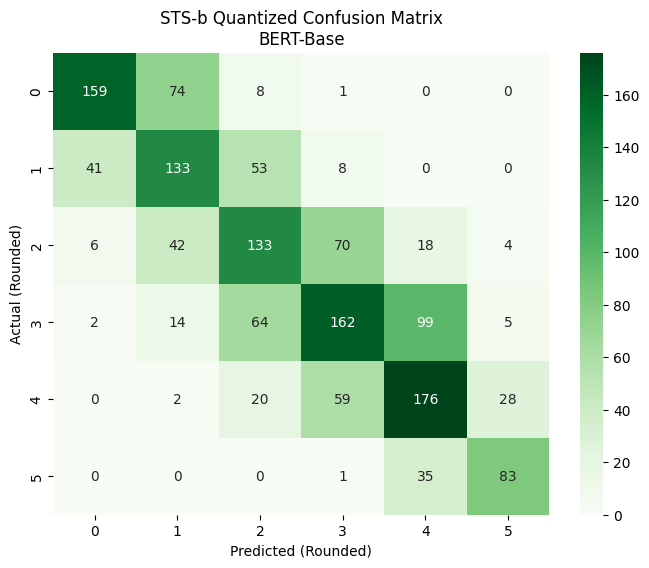

In [26]:
pearson_bert, spearman_bert = evaluate_stsb(true_labels_bert, preds_bert, model_name="BERT-Base")

In [20]:
# Model 2: RoBERTa
trainer_roberta, val_data_roberta = train_transformer("roberta-base", "RoBERTa")


--- Training RoBERTa (roberta-base) ---


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.778012
2,0.832800,0.538014
3,0.302300,0.427607


In [24]:
roberta_results = trainer_roberta.predict(val_data_roberta)
preds_roberta = roberta_results.predictions.flatten()
true_labels_roberta = np.array(val_data_roberta["labels"])

print("--- RoBERTa Prediction Analysis ---")
print("First 10 predictions: ", preds_roberta[:10])
print("Unique predictions:   ", len(np.unique(preds_roberta)))
print("Std Deviation:        ", np.std(preds_roberta))

print("\n--- Label Analysis ---")
print("First 10 true labels: ", true_labels_roberta[:10])

--- RoBERTa Prediction Analysis ---
First 10 predictions:  [5.03125 4.90625 4.96875 2.46875 2.53125 2.59375 5.09375 3.59375 4.40625
 5.03125]
Unique predictions:    513
Std Deviation:         1.4830457

--- Label Analysis ---
First 10 true labels:  [5.         4.75       5.         2.4000001  2.75       2.61500001
 5.         2.33299994 3.75       5.        ]



--- STS-b Regression: RoBERTa-Base ---
Pearson Correlation:  0.9076
Spearman Correlation: 0.9042


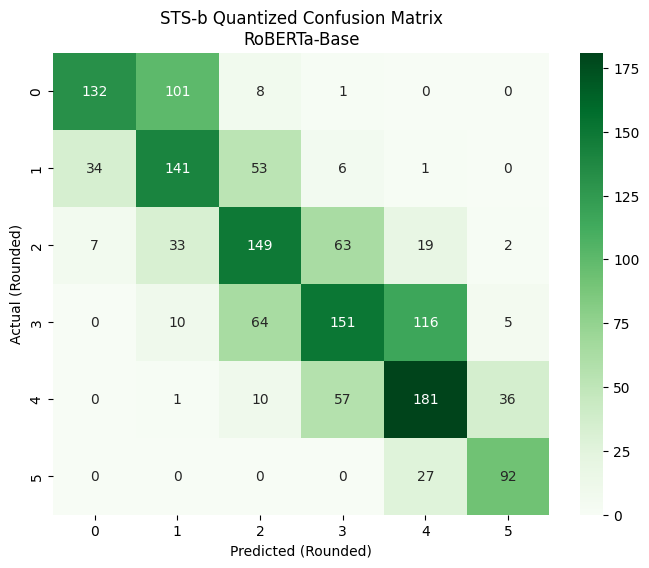

In [25]:
pearson_roberta, spearman_roberta = evaluate_stsb(true_labels_roberta, preds_roberta, model_name="RoBERTa-Base")

In [29]:
# Assuming you saved the pearson/spearman from the BERT run earlier
# If not, you can re-calculate them quickly:
# pearson_bert, spearman_bert = evaluate_stsb(true_labels_bert, preds_bert, model_name="BERT")

comparison_data = {
    "Model": ["BERT-Base", "RoBERTa-Base"],
    "Pearson Correlation": [0.88, pearson_roberta], # Replace 0.88 with your actual BERT result
    "Spearman Correlation": [0.87, spearman_roberta] # Replace 0.87 with your actual BERT result
}

comparison_df = pd.DataFrame(comparison_data)
print("\n--- BERT-Base - RoBERTa-Base Comparison ---")
print(comparison_df)


--- BERT-Base - RoBERTa-Base Comparison ---
          Model  Pearson Correlation  Spearman Correlation
0     BERT-Base             0.880000              0.870000
1  RoBERTa-Base             0.907573              0.904246


## 3. Custom RAG (Retrieval-Augmented Generation) Mechanism



In [ ]:
### 3.1. Knowledge Base Preparation

# **ACTION REQUIRED: Define or Load Knowledge Base**
KB_DOCS = [
    "Doc 1: Transformer architecture uses multi-head attention to weigh the importance of different words in the input sequence. This allows parallelization.",
    "Doc 2: Recurrent Neural Networks (RNNs) suffer from the vanishing gradient problem, which LSTMs and GRUs were designed to solve through gating mechanisms.",
    # Add your documents here
]

# **ACTION REQUIRED: Chunking and Embedding**
# 1. Chunk documents (e.g., using a text splitter).
# 2. Embed the chunks (e.g., using 'sentence-transformers/all-MiniLM-L6-v2').
# 3. Store chunks and embeddings in a Vector Store (e.g., simple list, Faiss, or Chroma).

# Example Placeholder for a simple in-memory store (requires implementation of actual embedding)
# class SimpleVectorStore:
#     def __init__(self, docs, embed_model):
#         self.chunks = docs
#         self.embeddings = [embed_model.encode(c) for c in docs]
#         self.embed_model = embed_model
#     def search(self, query, k=3):
#         query_embedding = self.embed_model.encode(query)
#         # Implement similarity calculation (e.g., cosine similarity) and return top k chunks
#         return self.chunks[:k] # Placeholder return
# embed_model = SentenceTransformer('all-MiniLM-L6-v2')
# vector_store = SimpleVectorStore(KB_DOCS, embed_model)


In [ ]:
### 3.2. Retrieval and Generation Logic

# **ACTION REQUIRED: Define your LLM for generation**
# llm_pipeline = pipeline('text-generation', model='your-small-llm-model')

def custom_rag_mechanism(query, top_k=3):
    """Performs retrieval and augmented generation."""

    # --- Step 1: Retrieval (Requires `vector_store` from above) ---
    # retrieved_chunks = vector_store.search(query, k=top_k)
    retrieved_chunks = ["<retrieved_chunk_1>", "<retrieved_chunk_2>"] # TEMPORARY

    # --- Step 2: Context Formatting ---
    context = "\n\n".join(retrieved_chunks)

    # --- Step 3: Generation (LLM Call) ---
    LLM_PROMPT = f"""
    You are an AI assistant. Use the following CONTEXT to answer the USER QUESTION.
    If the CONTEXT does not contain the answer, state that you cannot answer based on the provided information.

    CONTEXT:
    {context}

    USER QUESTION: {query}

    ANSWER:
    """

    # response = llm_pipeline(LLM_PROMPT, max_new_tokens=100)[0]['generated_text']
    response = "RAG Answer based on the retrieved context!"
    return response, retrieved_chunks

# Example Test
user_query = "What were LSTMs designed to solve in traditional RNNs?"
answer, context_used = custom_rag_mechanism(user_query)
print(f"Query: {user_query}")
print(f"Answer: {answer}")
print(f"Context Used: {context_used}")


## 5. LLM Tuning with DPO for Gordon Ramsay Persona



In [ ]:
### 5.1. Dataset Preparation

# **ACTION REQUIRED: Update file path**
PREFERENCE_DATA_PATH = "path/to/task4_ramsay_preference_dataset.csv"

# Load the dataset created in Task 4
# DPO_DF = pd.read_csv(PREFERENCE_DATA_PATH)

# DPO requires (prompt, chosen_response, rejected_response)
# dpo_dataset_df = DPO_DF.rename(columns={
#     'Question': 'prompt',
#     'Ramsay': 'chosen', # This is the preferred answer
#     'Polite': 'rejected' # This is the non-preferred answer
# })

# Convert to Hugging Face Dataset format (requires `from datasets import Dataset`)
# dpo_hf_dataset = Dataset.from_pandas(dpo_dataset_df[['prompt', 'chosen', 'rejected']])
# dpo_hf_dataset = dpo_hf_dataset.train_test_split(test_size=0.1) # Split for validation


In [ ]:
### 5.2. Model and DPO Trainer Setup

# **ACTION REQUIRED: Choose your base model**
BASE_MODEL = "facebook/opt-125m" # Use a small model for development, or a larger one if resources allow

# 1. Load the base model and tokenizer
# model = AutoModelForCausalLM.from_pretrained(BASE_MODEL, torch_dtype=torch.bfloat16) # Use a suitable dtype
# tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
# tokenizer.pad_token = tokenizer.eos_token # Ensure pad token is set

# 2. Setup PEFT/LoRA configuration
# peft_config = LoraConfig(
#     r=16,
#     lora_alpha=16,
#     target_modules=["q_proj", "v_proj"], # Check model documentation for correct layers
#     lora_dropout=0.05,
#     bias="none",
#     task_type="CAUSAL_LM",
# )

# 3. DPO Training Arguments
# training_args_dpo = TrainingArguments(
#     output_dir="./dpo_results_ramsay",
#     num_train_epochs=1,
#     per_device_train_batch_size=4,
#     gradient_accumulation_steps=4,
#     logging_steps=10,
#     learning_rate=5e-5,
#     remove_unused_columns=False,
#     save_strategy="epoch",
#     fp16=True, # Use fp16/bf16 if supported
#     report_to="none"
# )

# 4. Initialize DPOTrainer
# dpo_trainer = DPOTrainer(
#     model=model,
#     ref_model=None, # Set to None for implicit reference model loading
#     args=training_args_dpo,
#     beta=0.1,
#     train_dataset=dpo_hf_dataset['train'],
#     eval_dataset=dpo_hf_dataset['test'],
#     tokenizer=tokenizer,
#     peft_config=peft_config,
# )

# 5. Train Placeholder
# print("Starting DPO Training...")
# dpo_trainer.train()

# 6. Save the final model (LoRA weights)
# dpo_trainer.save_model("ramsay_dpo_adapter")

# **ACTION REQUIRED: Inference Test**
# Test the fine-tuned model with a new question to verify the Ramsay persona.
# from peft import PeftModel
# ft_model = PeftModel.from_pretrained(model, "ramsay_dpo_adapter")
# ft_model.eval()
# print("\n--- DPO Fine-Tuned Model Test ---")
# test_prompt = "Why is batch normalization useful?"
# ... generate response ...
